In [ ]:
%matplotlib inline

In [64]:
# -*- coding: utf-8 -*-
"""
Code referenced from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py
"""

import pandas as pd
import torch
import torch.nn as nn
import gensim
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.optim as optim
import random
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device = {}".format(device))
MAX_LENGTH = 40
print("MAX SEQ LEN = " + str(MAX_LENGTH))

url='https://raw.githubusercontent.com/sdp009/Sarcasm_Target_NEE_S2S/main/dataset/train_raw.csv'
print("Loading dataset ...")
train_data=pd.read_csv(url)
row_index=[i for i in range(0,train_data.shape[0])]

print(train_data.head())
# print(row_index)

SOS_token = 0
EOS_token = 1


Device = cuda
MAX SEQ LEN = 40
Loading dataset ...
   ID  ...                     Target
0   0  ...    white supremacists, KKK
1   1  ...                       they
2   2  ...  the article, anti-Hillary
3   3  ...                    OUTSIDE
4   4  ...                     You're

[5 rows x 3 columns]


In [ ]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, (hidden,c_n) = self.lstm(output,(hidden,hidden))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, (hidden,c_n) = self.lstm(output, (hidden,hidden))

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

def preprocessor(data):
    """
    Tokenizing the sentences using regular expressions and NLTK library
    Input
    text: list of descriptions
    Output:
    alphabet_tokens: list of tokens
    """
    __tokenization_pattern = r'''(?x)          # set flag to allow verbose regexps
        \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
        | (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
        | \w+(?:-\w+)*        # words with optional internal hyphens
        | \.\.\.              # ellipsis
        | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

    ## call it using tokenizer.tokenize
    tokenizer = nltk.tokenize.regexp.RegexpTokenizer(__tokenization_pattern)
    tokens = tokenizer.tokenize(data)
    tokens=[token.lower() for token in tokens if token.isalpha()]
    alphabet_tokens = [token for token in tokens if token.isalpha()]
    #en_stopwords = set(nltk.corpus.stopwords.words('english'))
    #non_stopwords = [word for word in alphabet_tokens if not word in en_stopwords]
    #stemmer = nltk.stem.snowball.SnowballStemmer("english")
    #stems = [str(stemmer.stem(word)) for word in non_stopwords]
    return alphabet_tokens

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def prepareData(lang1, lang2,train_data):
    input_lang=Lang(lang1)
    output_lang=Lang(lang2) 
    for index,row in train_data.iterrows():
        input_lang.addSentence(row['Sarcastic Comment'])
        output_lang.addSentence(row['Target'])
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(row):
    input_tensor = tensorFromSentence(input_lang, row['Sarcastic Comment'])
    target_tensor = tensorFromSentence(output_lang, row['Target'])
    return (input_tensor, target_tensor)

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    

    
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(
      decoder_input, decoder_hidden, encoder_outputs)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach()  # detach from history as input

      loss += criterion(decoder_output, target_tensor[di])
      if decoder_input.item() == EOS_token:
        break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

def trainIters(encoder, decoder, n_iters, print_every=500, plot_every=500, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    sample_input = train_data.iloc[random.choice(row_index)]
    print("\nSample Input = {}\n\n".format(sample_input))
    print("\n========================================\n")

    training_pairs = [tensorsFromPair(train_data.loc[random.choice(row_index)])
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    print('Since :: Remaining :: % Complete :: AVG_LOSS')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # print("\nPlotting loss")
    showPlot(plot_losses)

    return plot_losses

TRAIN

In [ ]:
train_data['Sarcastic Comment']=train_data['Sarcastic Comment'].apply(preprocessor)
train_data['Target']=train_data['Target'].apply(preprocessor)

print("Preprocessed Training data")
print(train_data.head())

input_lang,output_lang=prepareData("Sarcastic Comment","Target",train_data)

hidden_size = 256
print("\nSetting *Coder Hidden size = " + str(hidden_size))
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

plot_losses_pts = trainIters(encoder1, attn_decoder1, 50000)

Preprocessed Training data
   ID  ...                      Target
0   0  ...  [white, supremacists, kkk]
1   1  ...                      [they]
2   2  ...              [the, article]
3   3  ...                   [outside]
4   4  ...                   [you, re]

[5 rows x 3 columns]
Sarcastic Comment 4758
Target 874

Setting *Coder Hidden size = 256

Sample Input = ID                                                                 954
Sarcastic Comment    [because, your, manual, labor, employed, ain, ...
Target                                                       [outside]
Name: 910, dtype: object




Since :: Remaining :: % Complete :: AVG_LOSS
0m 21s (- 35m 14s) (500 1%) 2.7508
0m 30s (- 25m 6s) (1000 2%) 2.1846
0m 40s (- 21m 38s) (1500 3%) 2.1375
0m 49s (- 19m 48s) (2000 4%) 2.1313
0m 58s (- 18m 38s) (2500 5%) 2.1088
1m 8s (- 17m 51s) (3000 6%) 2.1644
1m 17s (- 17m 13s) (3500 7%) 2.0255
1m 27s (- 16m 42s) (4000 8%) 2.0471
1m 36s (- 16m 16s) (4500 9%) 2.0582
1m 46s (- 15m 54s) (5000 

FINE-TUNING SAVED MODEL

In [ ]:
train_data['Sarcastic Comment']=train_data['Sarcastic Comment'].apply(preprocessor)
train_data['Target']=train_data['Target'].apply(preprocessor)

print("Preprocessed Training data")
print(train_data.head())

input_lang,output_lang=prepareData("Sarcastic Comment","Target",train_data)

encoder_from_saved = torch.load('NEE_encoder.pt')
attn_decoder_from_saved = torch.load('NEE_attn_decoder.pt')

loss_history = trainIters(encoder_from_saved, attn_decoder_from_saved, 65000)

Preprocessed Training data
   ID  ...                      Target
0   0  ...  [white, supremacists, kkk]
1   1  ...                      [they]
2   2  ...              [the, article]
3   3  ...                   [outside]
4   4  ...                   [you, re]

[5 rows x 3 columns]
Sarcastic Comment 4758
Target 874

Sample Input = ID                                                                 341
Sarcastic Comment    [yeah, you, are, right, i, suggest, we, start,...
Target                                                           [you]
Name: 321, dtype: object




Since :: Remaining :: % Complete :: AVG_LOSS
0m 25s (- 55m 43s) (500 0%) 0.4962
0m 36s (- 38m 31s) (1000 1%) 0.4676
0m 46s (- 32m 45s) (1500 2%) 0.4312
0m 56s (- 29m 48s) (2000 3%) 0.4157
1m 7s (- 27m 55s) (2500 3%) 0.3697
1m 17s (- 26m 41s) (3000 4%) 0.3959
1m 27s (- 25m 46s) (3500 5%) 0.3761
1m 38s (- 25m 0s) (4000 6%) 0.3707
1m 48s (- 24m 23s) (4500 6%) 0.3640
1m 59s (- 23m 53s) (5000 7%) 0.3356
2m 9s (- 23m 22s) (5500

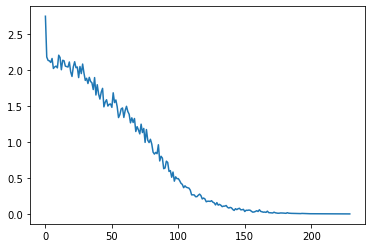

In [61]:
%matplotlib inline
fig = plt.figure()
overall_loss_history = plot_losses_pts + loss_history
plt.plot(overall_loss_history)

In [ ]:
# For now save entire model, as we need to switch device later
torch.save(encoder_from_saved, "NEE_encoder_v2.pt")
torch.save(attn_decoder_from_saved, "NEE_attn_decoder_v2.pt")

EVAL

In [ ]:
from difflib import SequenceMatcher

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attentions= decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #decoder_attentions[di] = decoder_attentions.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, sparse_set=False):
    Match_ratio = 0; entities = 0
    if sparse_set:
      for index,row in train_data[935:].iterrows():
          
          print('>', ' '.join(row['Sarcastic Comment']))
          print('=', ' '.join(row['Target']))
          output_words, attentions = evaluate(encoder, decoder, row['Sarcastic Comment'])
          output_sentence = ' '.join(output_words)
          print('Prediction >> ', output_sentence)
          
          Match_ratio += SequenceMatcher(None, row['Target'], output_sentence.split('<EOS>')[0]).ratio()
          entities = entities + 1
          print('Match ratio = {}\n\n'.format(Match_ratio))
    else:
        for index,row in train_data[801:].iterrows():
          
          print('>', ' '.join(row['Sarcastic Comment']))
          print('=', ' '.join(row['Target']))
          output_words, attentions = evaluate(encoder, decoder, row['Sarcastic Comment'])
          output_sentence = ' '.join(output_words)
          print('Prediction >> ', output_sentence)
          
          Match_ratio += SequenceMatcher(None, row['Target'], output_sentence.split('<EOS>')[0]).ratio()
          entities = entities + 1
          print('Match ratio = {}\n\n'.format(Match_ratio))

    print("DIS-Similarity ratio = {}".format(Match_ratio/entities))

evaluateRandomly(encoder_from_saved,attn_decoder_from_saved)

> actually i just saw him on a talk show talking about how relieved he was to get it he can finally move on with his life
= him he he
Prediction >>  him he he <EOS>
Match ratio = 0.0


> shame on you for missing the last sign post that hit the front page while you were asleep and then fell off before you got up
= outside
Prediction >>  outside <EOS>
Match ratio = 0.0


> yeah i should be able to send a videos of myself dancing to strangers but if they show it to any other strangers that s wrong
= i myself
Prediction >>  i myself <EOS>
Match ratio = 0.18181818181818182


> so all a new religion has to do is claim its new holy book has names of its god xyz and that will make it true
= a new religion
Prediction >>  a new religion <EOS>
Match ratio = 0.29292929292929293


> what kind of world is this where you can t even salute a genocidal dictator in a public memorial to those he killed without being chastised for it
= outside
Prediction >>  outside <EOS>
Match ratio = 0.29292929292929293

TEST SAVED MODEL

In [ ]:
encoder_eval = torch.load('NEE_encoder_v2.pt')
attn_decoder_eval = torch.load('NEE_attn_decoder_v2.pt')

evaluateRandomly(encoder_eval.eval(),attn_decoder_eval.eval(), sparse_set=True)

> i m sure that infertile women who can t have kids and instead have to have dogs that are their babies would totally agree with these real moms
= these real moms
Prediction >>  these real moms <EOS>
Match ratio = 0.0


> nice of them to broadcast these people s mugshots and charges so that we ll know what these monsters look like when they go on to commit mass murder
= them
Prediction >>  them <EOS>
Match ratio = 0.0


> just like obama was able to convince the nation that his healthcare law was in their best interests and they welcomed it with open arms and soaring approval ratings
= outside
Prediction >>  outside <EOS>
Match ratio = 0.0


> since plastic surgery is clearly addictive and dangerous shouldn t we ban it and jail anyone who has anything to do with it for the safety of the children
= outside
Prediction >>  outside <EOS>
Match ratio = 0.0


> oh thanks for defining hipster for me it a been such a mystery for these past few years of everybody on the internet pissing all ove